### Imports / globals

In [1]:
import os

import pandas as pd
import numpy as np

import cv2
from PIL import Image as PILImage

import torch
import torchvision
from torchvision import transforms
from sklearn.metrics import cohen_kappa_score

from tensorboardX import SummaryWriter

from efficientnet_pytorch import EfficientNet

from utils import get_split_indices, prepare_train_directories,\
                  threshold_logits, plot_batch
from utils.checkpoint import *
from models.model_factory import get_resnet50
from datasets.dataset_factory import SmallDataset, ExternalDataset
from utils.train_helpers import train, train_single_epoch, evaluate_single_epoch
from utils.find_lr import LRFinder
from transforms.transform_factory import get_uncorr_transform, get_uncorr_transform_noben

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

%load_ext autoreload
%autoreload 2

/home/l3404/anaconda3/envs/wombat/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

### External

v

In [3]:
NUM_FOLD = 0 #0-4
EXPERIMENT_NAME = 'effb4.fastai.ccben.pre_{}'.format(NUM_FOLD)
RESULTS_DIR = os.path.join('results', EXPERIMENT_NAME)
CHECKPOINT_DIR = os.path.join(RESULTS_DIR, 'checkpoint')
DATA_DIR = 'data'
# IMAGES_DIR = os.path.join(DATA_DIR, 'train-uncorr-260')
# IMAGES_EXTERNAL_DIR = os.path.join(DATA_DIR, 'external-uncorr-260')
IMAGES_DIR = os.path.join(DATA_DIR, 'train-cropped-1024')
IMAGES_EXTERNAL_DIR = os.path.join(DATA_DIR, 'external-1024') #-cropped
BATCH_SIZE = 32
IMAGE_SIZE = 260

prepare_train_directories(RESULTS_DIR)

In [4]:
df_ext = pd.read_csv(os.path.join(DATA_DIR, 'external-1024.csv')) #-cropped
df_ext = df_ext.rename(columns={'image': 'id_code', 'level': 'diagnosis'})
df_ext['path'] = df_ext['id_code'].apply(lambda x: os.path.join(IMAGES_EXTERNAL_DIR, x + '.jpeg'))
zeroes = df_ext[df_ext['diagnosis'] == 0].sample(n=5000, random_state=0)
df_ext = df_ext[df_ext.diagnosis != 0]
df_ext = pd.concat([df_ext, zeroes]).reset_index(drop=True)
df_ext['is_valid'] = False

df_new = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))#.loc[:100]
df_new['path'] = df_new['id_code'].apply(lambda x: os.path.join(IMAGES_DIR, x + '.png'))
df_new['is_valid'] = True

df = pd.concat([df_ext, df_new]).reset_index(drop=True)

In [5]:
def _gaussian_blur(img, radius=None, rel_size=None):
  if radius is None:
    radius = int(rel_size * img.shape[1])
  if radius % 2 == 0:
    radius = radius + 1
  img_numpy = img.permute(1, 2, 0).numpy()
  img_numpy = cv2.GaussianBlur(img_numpy, (radius, radius), 0)
  img = torch.Tensor(img_numpy).permute(2, 0, 1)
  return img

def _subtract_gaussian_blur(img, rel_size=.2, color_scale=1):
  img_blurred = _gaussian_blur(img, rel_size=rel_size)
  img = (4 * color_scale * (
            img - img_blurred)).sigmoid()  # sigmoid to squish to [0, 1]. Factor 4 because the slope of sigmoid at 0 is 4.
  return img

subtract_gaussian_blur = transforms.Compose([
    lambda img: _subtract_gaussian_blur(img, rel_size=.2, color_scale=2)])

In [6]:
def _load_format(path, convert_mode, after_open)->Image:
    image = PILImage.open(path)
    image = transforms.Resize(340)(image)
    image = transforms.CenterCrop(260)(image)
    image = transforms.ToTensor()(image)
    image = subtract_gaussian_blur(image)
    image = transforms.ToPILImage()(image)
                    
    return Image(pil2tensor(image, np.float32).div_(255)) #return fastai Image format

vision.data.open_image = _load_format

In [7]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=360, max_zoom=1.0, 
                      max_warp=0.0, max_lighting=0.2,
                      xtra_tfms=[cutout(n_holes=(8,8), length=(IMAGE_SIZE//10, IMAGE_SIZE//10)) ])

data = (ImageList.from_df(df=df,path='',cols='path') 
        .split_from_df(col='is_valid')
        #.split_by_rand_pct(0.2, seed=42)
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms) 
        .databunch(bs=BATCH_SIZE, num_workers=12) 
        .normalize(imagenet_stats)  
       )

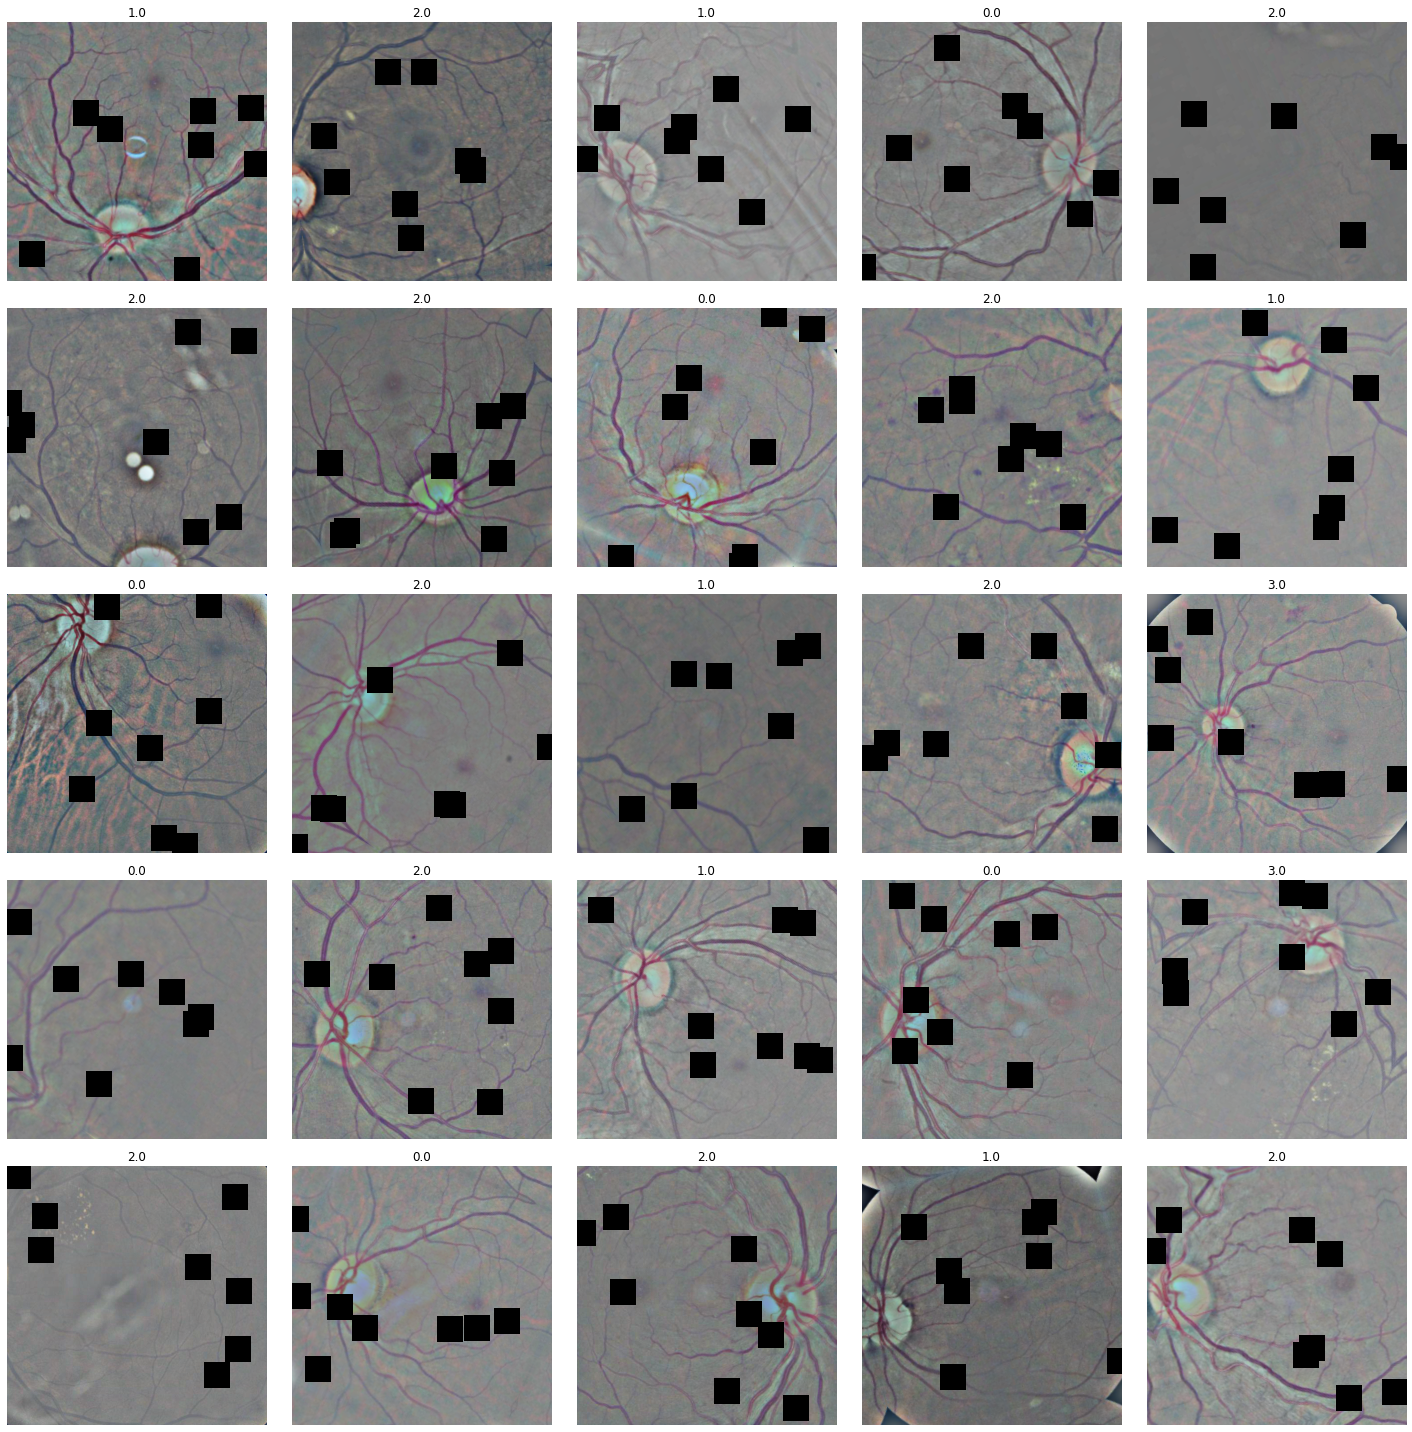

In [8]:
data.show_batch()

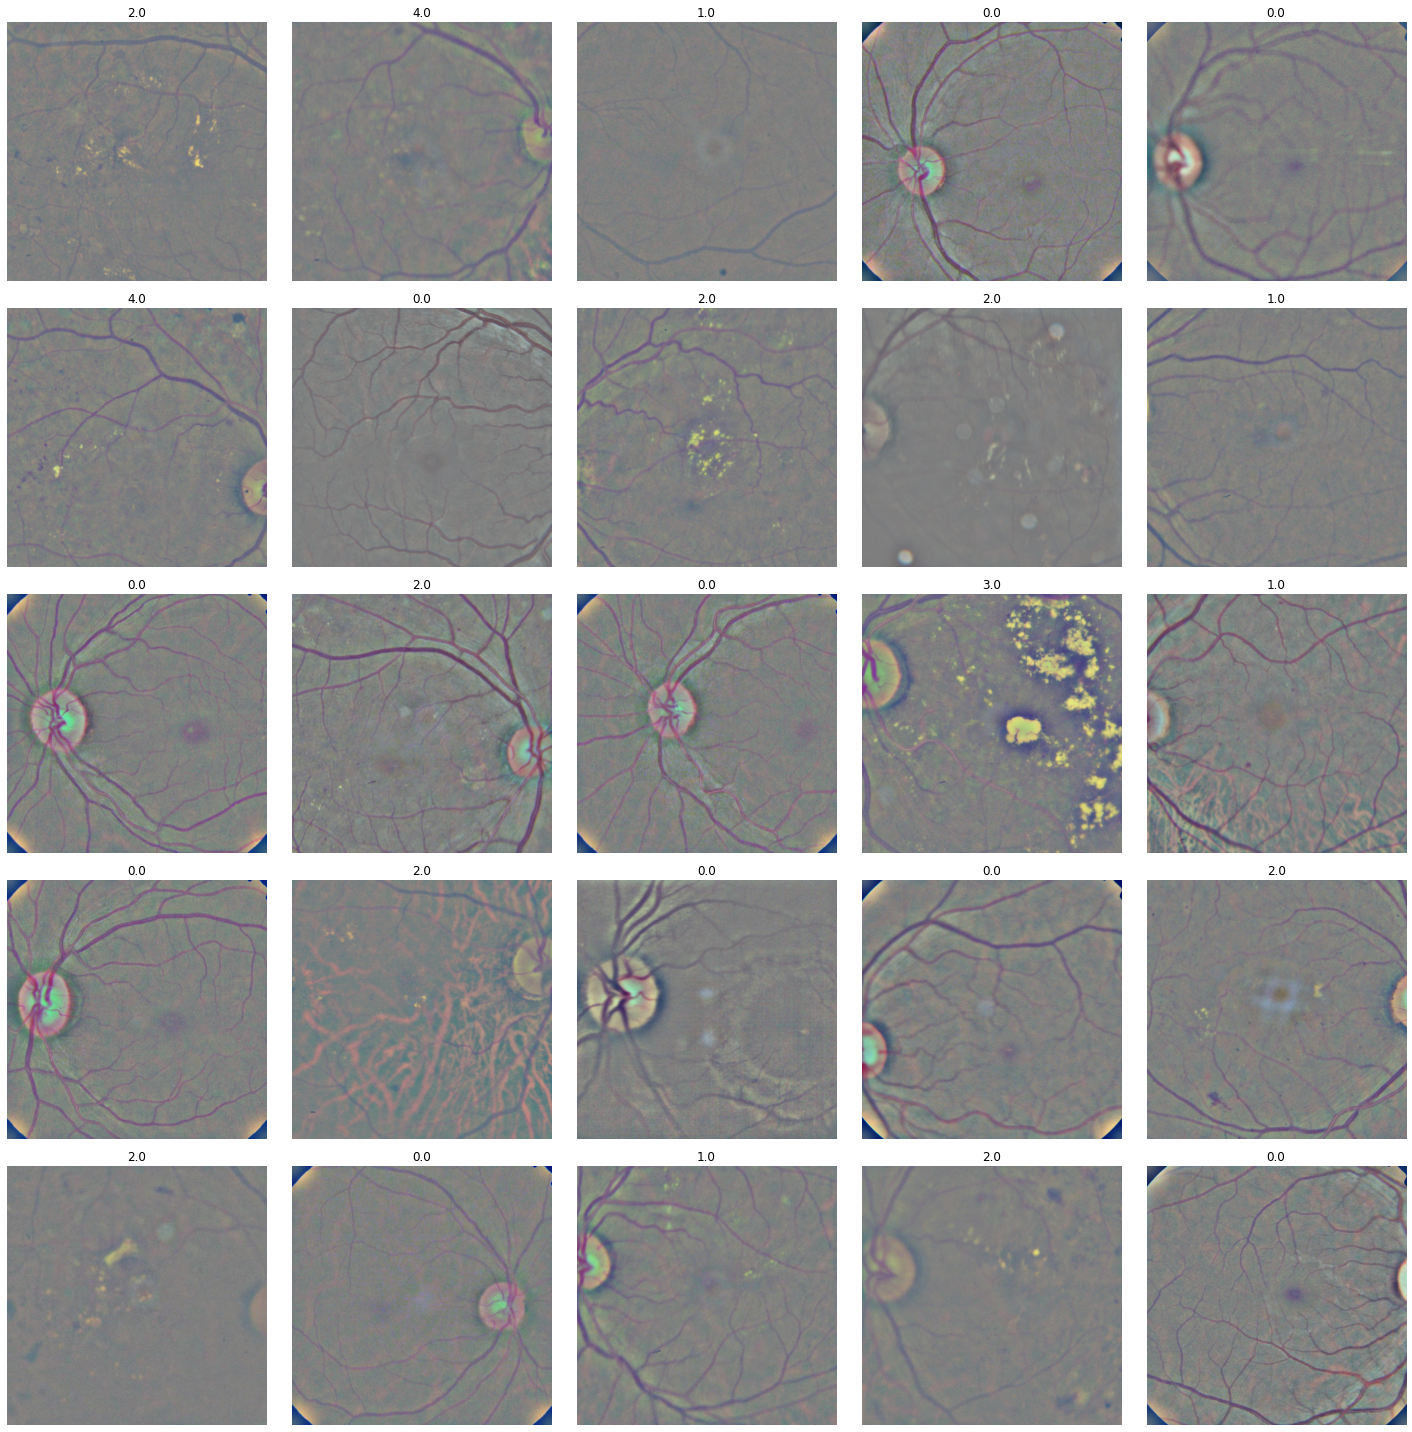

In [9]:
data.show_batch(ds_type=DatasetType.Valid)

In [8]:
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

In [11]:
# tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=360, max_zoom=1.0, 
#                       max_warp=0.0, max_lighting=0.2,
#                       xtra_tfms=[cutout(n_holes=(8,8), length=(IMAGE_SIZE//10, IMAGE_SIZE//10)) ])

In [12]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1) 
learn = Learner(data, model ,metrics=[quadratic_kappa],
                    model_dir=RESULTS_DIR, wd=1e-2).to_fp16()#.clip_grad(1)

Loaded pretrained weights for efficientnet-b4


In [13]:
lr = 1e-3
learn.fit_one_cycle(15, lr, callbacks=[SaveModelCallback(learn, every='improvement', 
                        monitor='valid_loss', name='bestmodel_{}'.format(EXPERIMENT_NAME))])

Better model found at epoch 0 with valid_loss value: 0.7236192226409912.
Better model found at epoch 1 with valid_loss value: 0.6098864674568176.
Better model found at epoch 4 with valid_loss value: 0.5821784734725952.
Better model found at epoch 8 with valid_loss value: 0.5482944250106812.
Better model found at epoch 9 with valid_loss value: 0.4724339246749878.


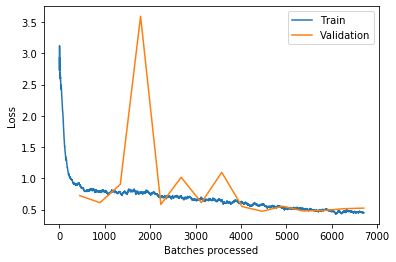

In [14]:
learn.recorder.plot_losses()

In [19]:
learn.save(EXPERIMENT_NAME, return_path=True)

PosixPath('results/effb4.fastai.ccben.pre_0/effb4.fastai.ccben.pre_0.pth')

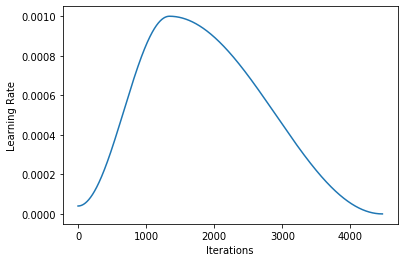

In [17]:
learn.recorder.plot_lr()

In [18]:
learn.save(EXPERIMENT_NAME, return_path=True)

PosixPath('results/effb4.fastai.uncorr.pre.v2-7_0/effb4.fastai.uncorr.pre.v2-7_0.pth')

In [ ]:
# import imgaug as ia
# import imgaug.augmenters as iaa

# seq = iaa.Sequential(
#     [
#         iaa.Fliplr(0.5),
        
#         iaa.Sometimes(0.5, iaa.Affine(
#             scale={'x': (0.95, 1.05), 'y': (0.95, 1.05)},
#             translate_percent={'x': (-0.01, 0.01), 'y': (-0.01, 0.01)},
#             rotate = (-5, 5))),
        
#         iaa.SomeOf((0, 2),
#             [
#                 iaa.Sharpen(alpha=(0, 0.5), lightness=(0.85, 1.15)),
#                 iaa.Emboss(alpha=(0, 0.5), strength=(0.8, 1.0)),
#                 iaa.Sometimes(0.3, iaa.EdgeDetect(alpha=(0, 0.3))),
#                 iaa.AdditiveGaussianNoise(),
#                 iaa.Multiply((0.9, 1.3)),
#                 iaa.ContrastNormalization((0.7, 1.2)),
#             ], random_order=True
#         )
#     ])

# # class my_trans(Transform):
# #     def __init__(self, tfm_y=transform.TfmType.NO):
# #         self.tfm_y = tfm_y
# #     def set_state(self):
# #         pass
# #     def do_transform(self, x,is_y):
# #         if is_y:
# #             return x
# #         else:
# #             x_aug = seq.augment_image(x)
# #             return x_aug
        
# def _my_tfm(x):
#     return seq.augment_image(x)
# my_tfm = TfmPixel(_my_tfm)

### Main data

In [1]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')) # external.csv
#df = df.rename(columns={'id_code': 'name', 'diagnosis': 'label'})
df['path'] = df['id_code'].apply(lambda x: os.path.join(IMAGES_DIR, x + '.png'))
#train_idx, val_idx = get_split_indices(df)[NUM_FOLD]
# train_df = df.iloc[train_idx]
# val_df = df.iloc[val_idx]

#df['is_valid'] = False
#df['is_valid'].iloc[val_idx] = True
#zeroes = df[df['diagnosis'] == 0].sample(n=5000, random_state=0)
#df = df[df.diagnosis != 0]
#df = pd.concat([df, zeroes]).reset_index()

NameError: name 'pd' is not defined

In [ ]:
transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.40, max_zoom=1.3, max_warp=0.0, max_lighting=0.2)

data = (ImageList.from_df(df=df,path='',cols='path') 
        #.split_from_df(col='is_valid')
        .split_by_rand_pct(0.2, seed=42)
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(transforms, size=260) 
        .databunch(bs=BATCH_SIZE, num_workers=12) 
        .normalize(imagenet_stats)  
       )

In [ ]:
data.show_batch()

In [ ]:
#model = torch.load('results/effb4.fastai.pre_0/effb4.fastai.pre_0-ext.pth')
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1) 
learn = Learner(data, model ,metrics=[quadratic_kappa],
                    model_dir=RESULTS_DIR).to_fp16()
learn.load('effb4.fastai.pre_0-ext1-fullset')

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 6e-3
learn.fit_one_cycle(3, lr)

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Submission

In [ ]:
sample_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
#sample_df = sample_df.rename(columns={'id_code': 'name', 'diagnosis': 'label'})
sample_df['path'] = sample_df['id_code'].apply(lambda x: os.path.join('data/test', x + '.png'))

In [ ]:
# optlr -- 
# valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
# optR = OptimizedRounder()
# optR.fit(valid_preds[0],valid_preds[1])
# coefficients = optR.coefficients()
# print(coefficients)

In [ ]:
preds = threshold_logits(preds)

In [ ]:
sample_df.diagnosis = preds.astype(int)
sample_df.drop('path', axis=1, inplace=True)
sample_df.head()

In [ ]:
sub_name = 'submission_{}_{}_v2.csv'.format(EXPERIMENT_NAME, NUM_FOLD)
sample_df.to_csv(sub_name,index=False)